In [1]:
from pathlib import Path

METRICS_DIR = Path("eval/metrics")
evaluations = list(METRICS_DIR.glob("*.json"))


In [2]:
import json

model_evaluations = {}

for evaluation_json in evaluations:
    with open(evaluation_json, "r", encoding="utf-8") as f:
        model_evaluations[evaluation_json.stem] = json.load(f)

# model_evaluations: {model_name: {query: result}}

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

data = {}
for model, queries in model_evaluations.items():
    df = pd.DataFrame(queries).T
    data[model] = df.mean()

df_summary = pd.DataFrame(data).T


In [25]:
df_summary.sort_values("map", ascending=True, inplace=True)

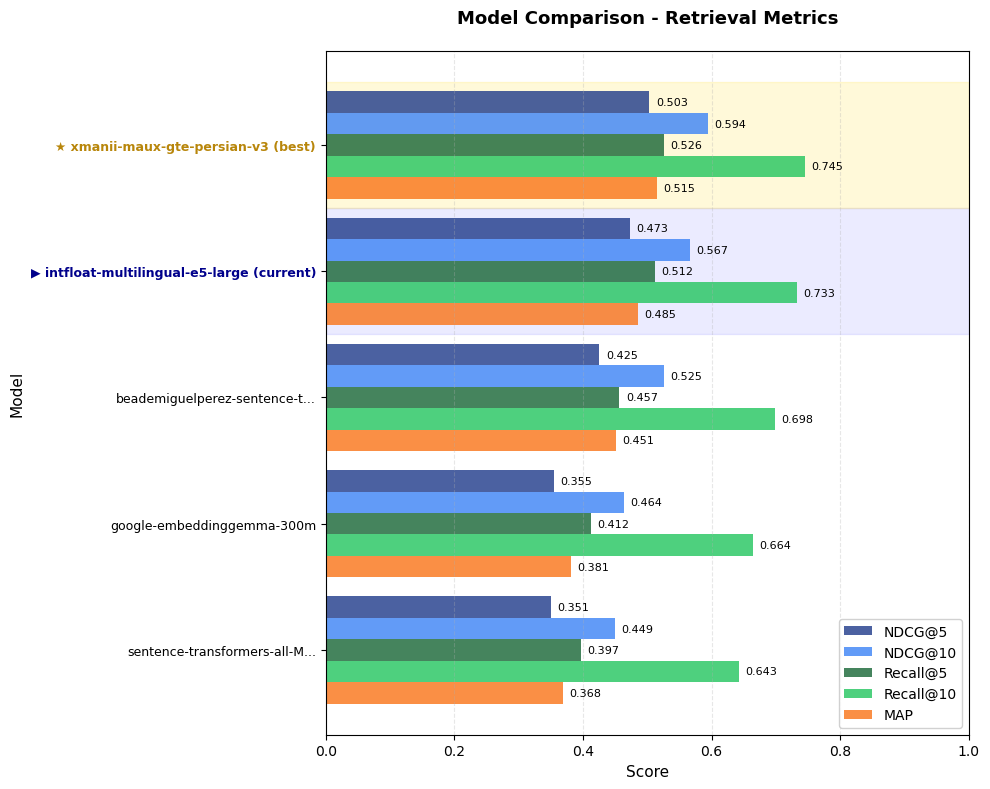

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create figure with better size for horizontal bars
fig, ax = plt.subplots(figsize=(10, 8))

# Prepare data
metrics = ["ndcg_cut_5", "ndcg_cut_10", "recall_5", "recall_10", "map"]
metric_labels = ["NDCG@5", "NDCG@10", "Recall@5", "Recall@10", "MAP"]
models = df_summary.index.tolist()

# Define special models
current_model = "intfloat-multilingual-e5-large"
best_model = "xmanii-maux-gte-persian-v3"

# Define colors - shades of blue for NDCG, shades of green for Recall, orange for MAP
colors = [
    "#1e3a8a",
    "#3b82f6",
    "#166534",
    "#22c55e",
    "#f97316",
]  # dark blue, light blue, dark green, light green, orange


# Truncate model names and add tooltips
def truncate_name(name, max_length=30):
    if len(name) <= max_length:
        return name
    return name[: max_length - 3] + "..."


truncated_names = [truncate_name(model) for model in models]

# Add markers to special models
for i, model in enumerate(models):
    if model == current_model:
        truncated_names[i] = "▶ " + truncated_names[i] + " (current)"
    elif model == best_model:
        truncated_names[i] = "★ " + truncated_names[i] + " (best)"

# Set up bar positions
x = np.arange(len(models))
width = 0.17

# Create bars for each metric with specified colors
plots = [
    ax.barh(
        x + (len(metrics) // 2 - i) * width,
        df_summary[metrics[i]],
        width,
        label=metric_labels[i],
        alpha=0.8,
        color=colors[i],
    )
    for i in range(len(metrics))
]

# Highlight special model rows with background color
for i, model in enumerate(models):
    if model == current_model:
        ax.axhspan(i - 0.5, i + 0.5, color="blue", alpha=0.08, zorder=0)
    elif model == best_model:
        ax.axhspan(i - 0.5, i + 0.5, color="gold", alpha=0.15, zorder=0)

# Customize the plot
ax.set_xlabel("Score", fontsize=11)
ax.set_ylabel("Model", fontsize=11)
ax.set_title(
    "Model Comparison - Retrieval Metrics", fontsize=13, fontweight="bold", pad=20
)
ax.set_yticks(x)
ax.set_yticklabels(truncated_names, fontsize=9)

# Make special model labels bold and colored
for i, (tick, model) in enumerate(zip(ax.get_yticklabels(), models)):
    if model == current_model:
        tick.set_weight("bold")
        tick.set_color("darkblue")
    elif model == best_model:
        tick.set_weight("bold")
        tick.set_color("darkgoldenrod")

ax.set_xlim(0, 1)
ax.legend(loc="lower right", framealpha=0.9)
ax.grid(axis="x", alpha=0.3, linestyle="--")

# Add value labels on bars
for bars in plots:
    for bar in bars:
        width_val = bar.get_width()
        ax.text(
            width_val + 0.01,
            bar.get_y() + bar.get_height() / 2,
            f"{width_val:.3f}",
            ha="left",
            va="center",
            fontsize=8,
        )

plt.tight_layout()
plt.show()

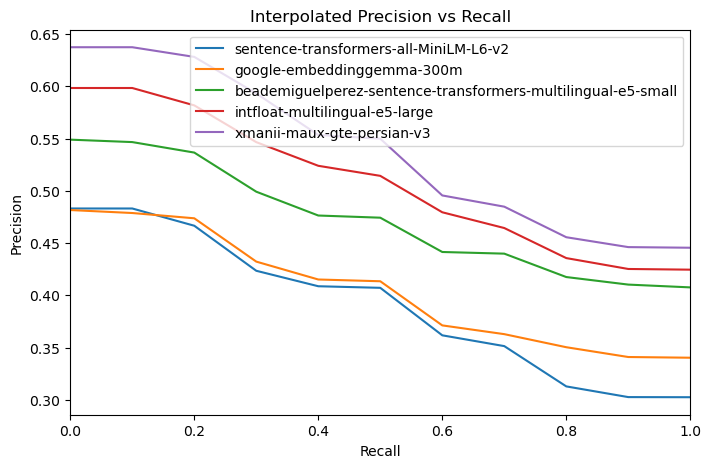

In [44]:
import re

iprec_cols = [c for c in df_summary.columns if re.match(r"iprec_at_recall_", c)]
df_iprec = df_summary[iprec_cols].T
df_iprec.index = [float(c.split("_")[-1]) for c in iprec_cols]
df_iprec.plot(figsize=(8, 5), title="Interpolated Precision vs Recall")
plt.xlim(0, 1)
# plt.ylim(top=1)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()


In [9]:
from pydantic_ai import Agent
from pydantic_ai.models.openai import OpenAIChatModel
from pydantic import BaseModel


class TopicalKeywords(BaseModel):
    keywords: list[str]


model = OpenAIChatModel(
    "anthropic/claude-3.5-sonnet",  # or any other OpenRouter model
    base_url="https://openrouter.ai/api/v1",
    api_key=os.environ["OPENROUTER_KEY"],
)


agent = Agent(model, output_type=TopicalKeywords)
result = await agent.run("What is the meaning of life?")
print(result)


TypeError: OpenAIChatModel.__init__() got an unexpected keyword argument 'base_url'

,keyword,similarity
0,بهترین هتل آنتالیا,0.932635
1,بهترین رستوران های استانبول,0.924617
2,بهترین فیلم های ترکی,0.924617
3,بهترین سریال های ترکی,0.922889
4,بهترین آهنگ های ترکی,0.918650
...,...,...
95,هتل های نوشهر,0.874185
96,هتل سانتا صوفیا استانبول,0.874109
97,رستوران های خوب تهران,0.873998
98,لیست مسافرخانه های تهران,0.873973


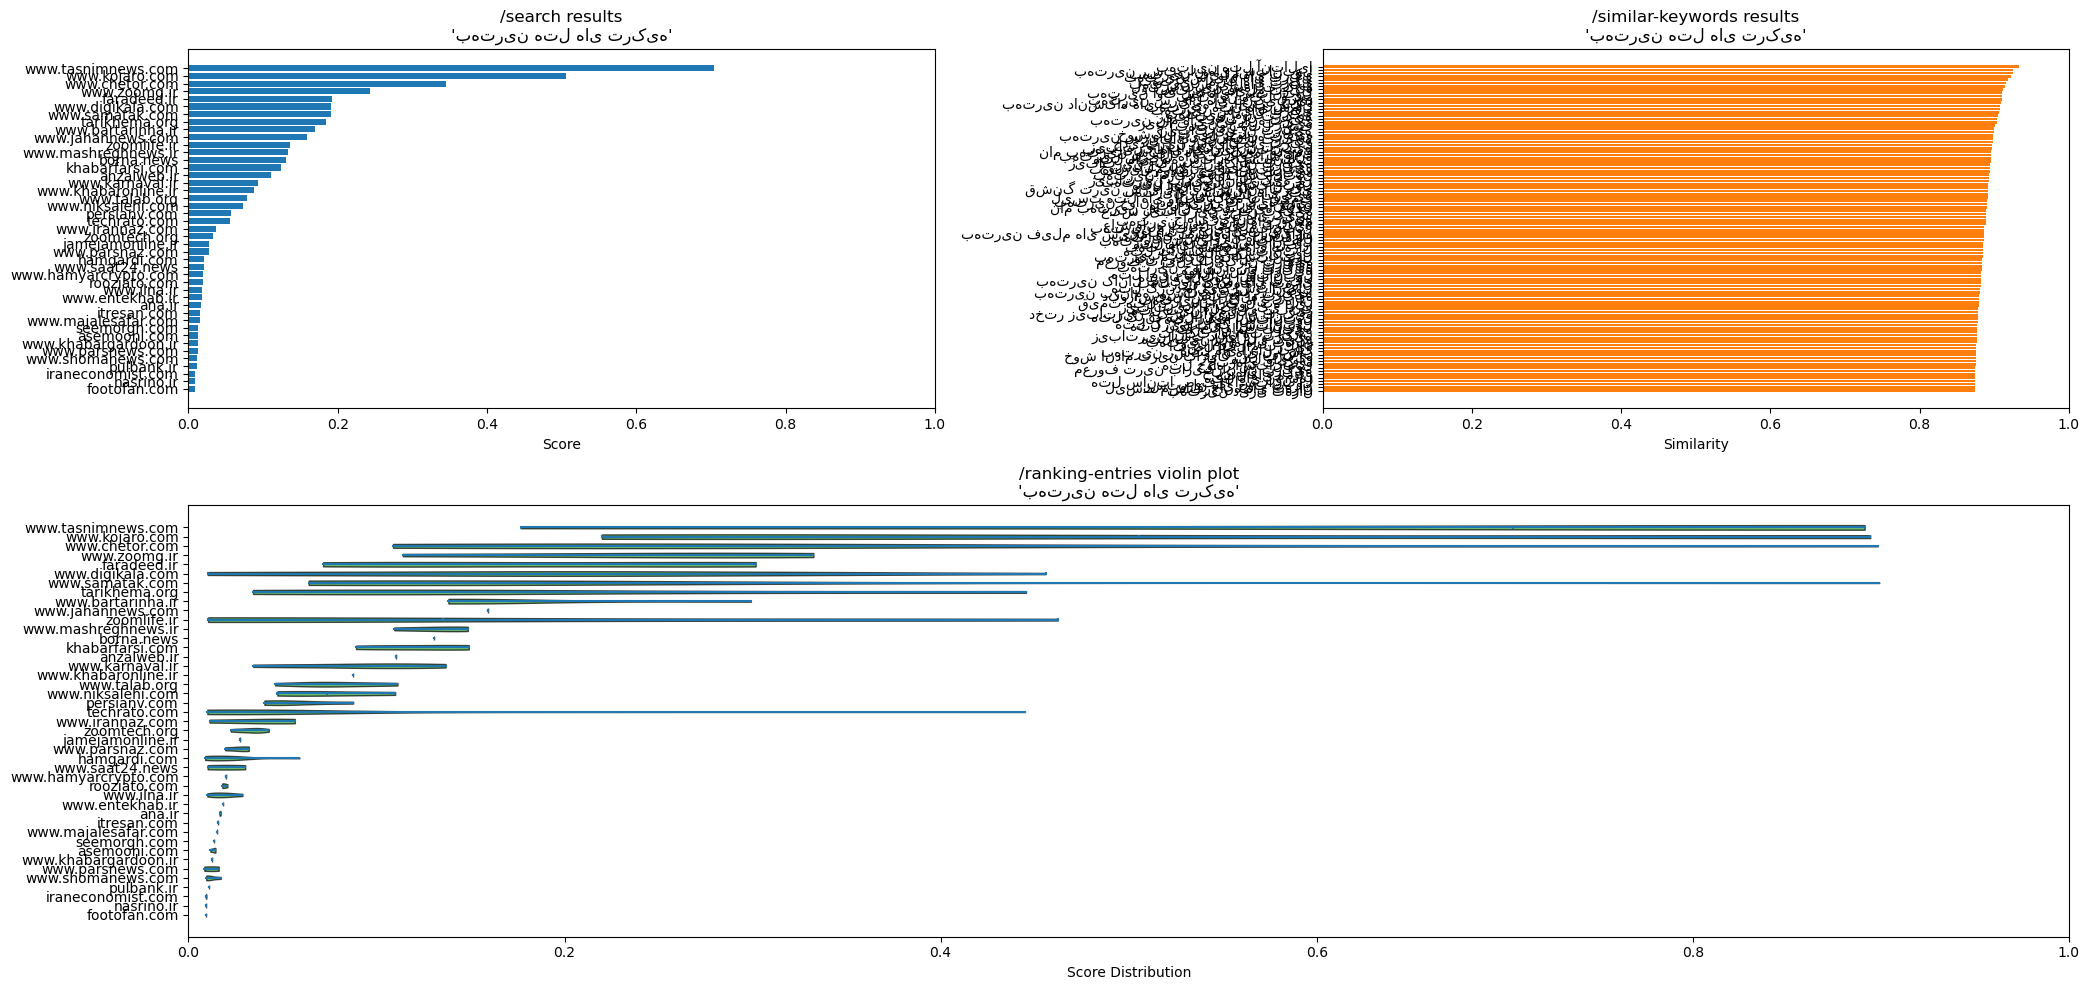

In [ ]:
import requests
import matplotlib.pyplot as plt
import pandas as pd

# --- CONFIG ---
BASE_URL = "http://185.8.172.121:8000"  # change to your server


def query_api(
    endpoint: str,
    query: str,
    top_k: int | None = None,
    **params,
) -> pd.DataFrame:
    """
    Sends a GET request to a given endpoint and returns a normalized DataFrame.
    The endpoint may contain 'score' or 'similarity' columns.
    """
    url = f"{BASE_URL}/{endpoint}"
    params = {"query": query, "top_k": top_k, **params}
    response = requests.get(url, params=params)
    response.raise_for_status()
    data = response.json()
    df = pd.DataFrame(data)

    return df


def visualize_all(df_search, df_similar, df_ranking, query):
    """Displays a 2x2 layout with search, similar-keywords, and ranking-entries violin plots."""
    # --- Prepare figure layout ---
    fig = plt.figure(figsize=(21, 10))
    gs = fig.add_gridspec(2, 2, height_ratios=[1, 1.2])
    ax_search = fig.add_subplot(gs[0, 0])
    ax_similar = fig.add_subplot(gs[0, 1])
    ax_violin = fig.add_subplot(gs[1, :])  # full width bottom row

    # --- /search ---
    df = df_search.sort_values("score", ascending=True)
    ax_search.barh(df["website"], df["score"], color="#1f77b4")
    ax_search.set_title(f"/search results\n'{query}'")
    ax_search.set_xlabel("Score")
    ax_search.set_xlim(0, 1)

    # --- /similar-keywords ---
    df = df_similar.sort_values("similarity", ascending=True)
    ax_similar.barh(df["keyword"], df["similarity"], color="#ff7f0e")
    ax_similar.set_title(f"/similar-keywords results\n'{query}'")
    ax_similar.set_xlabel("Similarity")
    ax_similar.set_xlim(0, 1)

    # --- /ranking-entries violin plot ---
    # Create a combined score metric
    df_ranking["score"] = df_ranking["similarity"] / df_ranking["average_position"]

    # Compute mean score per website and sort
    mean_scores = df_ranking.groupby("website")["score"].mean().sort_values()
    labels = mean_scores.index.tolist()

    # Group by website for violin data
    grouped = [
        df_ranking[df_ranking["website"] == site]["score"].values for site in labels
    ]

    parts = ax_violin.violinplot(grouped, showmeans=True, showmedians=False, vert=False)
    for pc in parts["bodies"]:
        pc.set_facecolor("#2ca02c")
        pc.set_edgecolor("black")
        pc.set_alpha(0.7)

    ax_violin.set_yticks(range(1, len(labels) + 1))
    ax_violin.set_yticklabels(labels)
    ax_violin.set_xlabel("Score Distribution")
    ax_violin.set_title(f"/ranking-entries violin plot\n'{query}'")
    ax_violin.set_xlim(0, 1)

    plt.tight_layout()
    plt.show()


# --- Example usage ---
query = "بهترین هتل های ترکیه"
top_k = 100

df_search = query_api("search", query, top_k)
df_similar = query_api("similar-keywords", query, top_k, augment)
df_ranking = query_api("ranking-entries", query, top_k)

display(df_similar)
visualize_all(df_search, df_similar, df_ranking, query)


In [ ]:
import pickle

with open("")
pickle.load()

In [59]:
import asyncio
import aiohttp

import os
from openai import OpenAI
import json
import dotenv

dotenv.load_dotenv()

client = OpenAI(
    base_url="https://openrouter.ai/api/v1",
    api_key=os.environ["OPENROUTER_KEY"],
)

query = "بهترین هتل های ترکیه"

prompt = f"""
You are an SEO keyword assistant specialized in Persian search queries.
Given the query "{query}", generate 5 to 10 semantically related search keywords
that focus on the same *topic* ({query.split()[-1]}), not on other products.
Include a mix of informational and commercial intents, but all must clearly
belong to the same topical field.
Return the result as a compact JSON array of strings, with no explanations.
"""

completion = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[{"role": "user", "content": prompt}],
    # temperature=0.3,
    response_format={
        "type": "json_schema",
        "json_schema": {
            "name": "topical_keywords_response",
            "strict": True,
            "schema": {
                "type": "object",
                "properties": {
                    "topical_terms": {
                        "type": "array",
                        "items": {"type": "string"},
                    },
                },
                "required": ["topical_terms"],
                "additionalProperties": False,
            },
        },
    },
)

# Parse and print
resp = completion.choices[0].message.content.strip()

try:
    keywords = json.loads(resp)["topical_terms"]

except json.JSONDecodeError:
    # fallback if model adds text
    keywords = [k.strip() for k in resp.split("\n") if k.strip()]

print(keywords)


async def query_api_async(
    session: aiohttp.ClientSession,
    endpoint: str,
    query: str,
    top_k: int | None = None,
    index: str | None = None,
) -> pd.DataFrame:
    """
    Sends a GET request to a given endpoint and returns a normalized DataFrame.
    The endpoint may contain 'score' or 'similarity' columns.
    """
    url = f"{BASE_URL}/{endpoint}"
    params = {"query": query, "top_k": top_k}
    async with session.get(url, params=params) as response:
        response.raise_for_status()
        data = await response.json()
        df = pd.DataFrame(data)
        if index is not None:
            df = df.set_index(index)

    return df


top_k = 128
async with aiohttp.ClientSession() as session:
    tasks = [
        asyncio.create_task(
            query_api_async(
                session,
                "similar-keywords",
                query=keyword,
                top_k=top_k,
                index="keyword",
            )
        )
        for keyword in keywords
    ]

    results = await asyncio.gather(*tasks)

# Merge all DataFrames by keyword and create a column for each
df_merged = pd.concat(results, axis=1)

# Take the average and replace NaN with 0
average_scores = df_merged.fillna(0).mean(axis=1)
average_scores.sort_values(ascending=False).head(20)

['هتل های لوکس در ترکیه', 'بهترین رستوران های ترکیه', 'جاذبه های گردشگری ترکیه', 'رزرو هتل در استانبول', 'سفر به ترکیه با خانواده', 'هتل های ساحلی ترکیه', 'راهنمای سفر به ترکیه', 'ترکیه یا یونان برای سفر', 'آفرهای هتل در ترکیه', 'مقایسه هتل های ترکیه']


keyword
جاهای دیدنی ترکیه             0.802916
در ترکیه                      0.794504
هواشناسی ترکیه                0.789987
دکوراسیون آشپزخانه ترکیه      0.706277
کارت اقامت ترکیه              0.704329
مکان های دیدنی استانبول       0.618690
آب و هوای ترکیه               0.617713
لوکس ترین شهر ترکیه           0.616335
نقشه ی ترکیه                  0.613816
جاذبه های گردشگری استانبول    0.534290
آب و هوا ترکیه                0.528749
بلیط ترکیه به تهران           0.528740
شیرینی های ترکیه              0.526952
ترکیه به انگلیسی              0.523988
اوقات نماز در ترکیه           0.522566
نرخ ارز در ترکیه              0.521781
سایت بررسی پرونده ترکیه       0.521100
قیمت یورو در ترکیه            0.520989
قیمت پوند در ترکیه            0.520570
هتل ایرانی در استانبول        0.450103
dtype: float64

In [5]:
df_similar.sample(20).sort_values("similarity", ascending=False)

,keyword,similarity
0,بهترین هتل آنتالیا,0.932635
2,بهترین فیلم های ترکی,0.924617
4,بهترین آهنگ های ترکی,0.918650
9,بهترین هتل قشم,0.910547
18,بهترین هتل رشت,0.901292
23,جدیدترین سریال های ترکی,0.898304
24,زیباترین بازیگران زن ترکیه,0.897214
32,جدیدترین اخبار ترکیه,0.894263
38,بهترین رستوران های دبی,0.891631
40,لیست هتل های وان ترکیه با قیمت,0.891050
